In [1]:
import pandas as pd
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Load the dataset
file_path = "lung_cancer_data.csv"  # Ensure the correct file path
lung_cancer_data = pd.read_csv(file_path)

# Display basic information
lung_cancer_data.info()

# Show the first few rows
lung_cancer_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23658 entries, 0 to 23657
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Patient_ID                        23658 non-null  object 
 1   Age                               23658 non-null  int64  
 2   Gender                            23658 non-null  object 
 3   Smoking_History                   23658 non-null  object 
 4   Tumor_Size_mm                     23658 non-null  float64
 5   Tumor_Location                    23658 non-null  object 
 6   Stage                             23658 non-null  object 
 7   Treatment                         23658 non-null  object 
 8   Survival_Months                   23658 non-null  int64  
 9   Ethnicity                         23658 non-null  object 
 10  Insurance_Type                    23658 non-null  object 
 11  Family_History                    23658 non-null  object 
 12  Como

,Patient_ID,Age,Gender,Smoking_History,Tumor_Size_mm,Tumor_Location,Stage,Treatment,Survival_Months,Ethnicity,...,Alanine_Aminotransferase_Level,Aspartate_Aminotransferase_Level,Creatinine_Level,LDH_Level,Calcium_Level,Phosphorus_Level,Glucose_Level,Potassium_Level,Sodium_Level,Smoking_Pack_Years
0,Patient0000,68,Male,Current Smoker,81.678677,Lower Lobe,Stage III,Surgery,44,Hispanic,...,27.985571,46.801214,1.245849,239.240255,10.366307,3.547734,113.919243,4.968163,139.822861,17.006956
1,Patient0001,58,Male,Never Smoked,78.448272,Lower Lobe,Stage I,Radiation Therapy,101,Caucasian,...,30.120956,39.711531,1.463231,233.515237,10.081731,2.945020,101.321578,3.896795,135.449361,93.270893
2,Patient0002,44,Male,Former Smoker,67.714305,Lower Lobe,Stage I,Chemotherapy,69,African American,...,5.882418,32.640602,0.630109,169.037460,8.660892,4.637399,78.214177,4.369050,143.377155,70.348376
3,Patient0003,72,Male,Current Smoker,70.806008,Lower Lobe,Stage III,Chemotherapy,95,African American,...,38.908154,44.319393,0.594342,213.967590,8.832669,3.617098,127.895361,4.348474,138.586005,19.828128
4,Patient0004,37,Female,Never Smoked,87.272433,Lower Lobe,Stage IV,Radiation Therapy,105,Asian,...,26.344877,15.746906,1.478239,118.187543,9.247609,4.773255,148.801185,3.671976,141.230724,81.047456


In [2]:
# STEP 2: Load the dataset
file_path = "lung_cancer_data.csv"
lung_cancer_data = pd.read_csv(file_path, low_memory=False)


In [3]:
# STEP 3: Handle missing values
for col in lung_cancer_data.columns:
    if lung_cancer_data[col].isnull().sum() > 0:
        if lung_cancer_data[col].dtype == "object":
            lung_cancer_data[col].fillna(lung_cancer_data[col].mode()[0], inplace=True)
        else:
            lung_cancer_data[col].fillna(lung_cancer_data[col].mean(), inplace=True)

In [4]:
# STEP 4: Convert Stage to binary target: Early (0), Advanced (1)
lung_cancer_data["Stage_Binary"] = lung_cancer_data["Stage"].apply(
    lambda x: 0 if x in ["Stage I", "Stage II"] else 1
)

In [5]:
def detect_outliers(df, numerical_columns):
    """
    Detects outliers in numerical columns using the IQR method.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
        numerical_columns (list): List of numerical column names to check for outliers.
    
    Returns:
        dict: A dictionary with column names as keys and the number of detected outliers as values.
    """
    outliers = {}
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers[col] = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    return outliers

# Define numerical columns
numerical_columns = lung_cancer_data.select_dtypes(include=["number"]).columns.tolist()

# Apply function
outliers_detected = detect_outliers(lung_cancer_data, numerical_columns)

# Display outliers detected per numerical column
outliers_detected


{'Age': 0,
 'Tumor_Size_mm': 0,
 'Survival_Months': 0,
 'Performance_Status': 0,
 'Blood_Pressure_Systolic': 0,
 'Blood_Pressure_Diastolic': 0,
 'Blood_Pressure_Pulse': 0,
 'Hemoglobin_Level': 0,
 'White_Blood_Cell_Count': 0,
 'Platelet_Count': 0,
 'Albumin_Level': 0,
 'Alkaline_Phosphatase_Level': 0,
 'Alanine_Aminotransferase_Level': 0,
 'Aspartate_Aminotransferase_Level': 0,
 'Creatinine_Level': 0,
 'LDH_Level': 0,
 'Calcium_Level': 0,
 'Phosphorus_Level': 0,
 'Glucose_Level': 0,
 'Potassium_Level': 0,
 'Sodium_Level': 0,
 'Smoking_Pack_Years': 0,
 'Stage_Binary': 0}

In [6]:
# STEP 5: Drop unnecessary columns
if "Patient_ID" in lung_cancer_data.columns:
    lung_cancer_data.drop(columns=["Patient_ID"], inplace=True)
lung_cancer_data.drop(columns=["Stage"], inplace=True)


In [7]:
# STEP 6: Encode all categorical columns
for col in lung_cancer_data.select_dtypes(include="object").columns:
    lung_cancer_data[col] = LabelEncoder().fit_transform(lung_cancer_data[col])

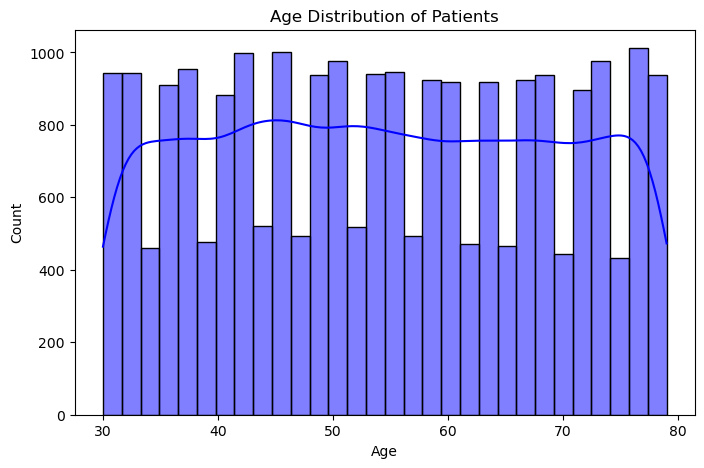

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_age_distribution(df):
    """
    Plots the distribution of age in the dataset.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
    """
    plt.figure(figsize=(8,5))
    sns.histplot(df["Age"], bins=30, kde=True, color="blue")
    plt.title("Age Distribution of Patients")
    plt.xlabel("Age")
    plt.ylabel("Count")
    plt.show()

# Apply function
plot_age_distribution(lung_cancer_data)


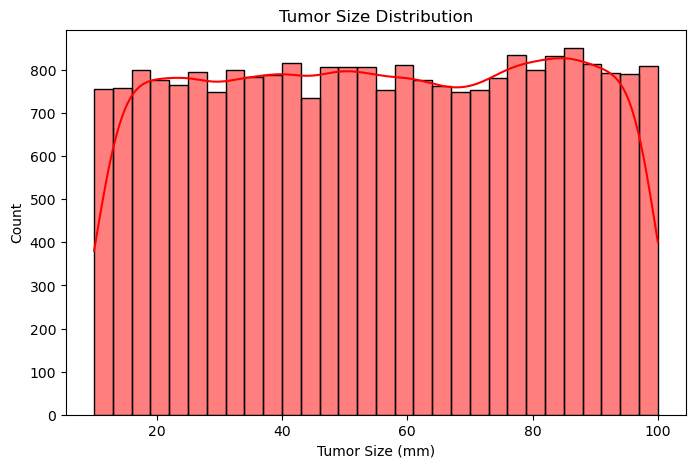

In [9]:
def plot_tumor_size_distribution(df):
    """
    Plots the distribution of tumor size in the dataset.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
    """
    plt.figure(figsize=(8,5))
    sns.histplot(df["Tumor_Size_mm"], bins=30, kde=True, color="red")
    plt.title("Tumor Size Distribution")
    plt.xlabel("Tumor Size (mm)")
    plt.ylabel("Count")
    plt.show()

# Apply function
plot_tumor_size_distribution(lung_cancer_data)


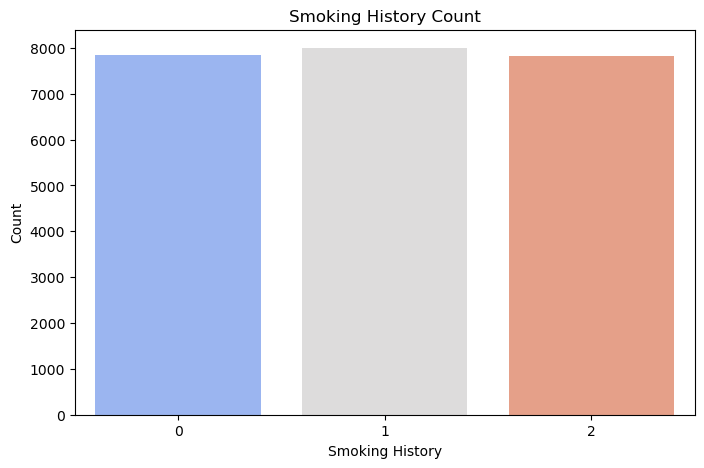

In [10]:
def plot_smoking_history(df):
    """
    Plots the count distribution of smoking history.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
    """
    plt.figure(figsize=(8,5))
    sns.countplot(x="Smoking_History", data=df, palette="coolwarm")
    plt.title("Smoking History Count")
    plt.xlabel("Smoking History")
    plt.ylabel("Count")
    plt.show()

# Apply function
plot_smoking_history(lung_cancer_data)


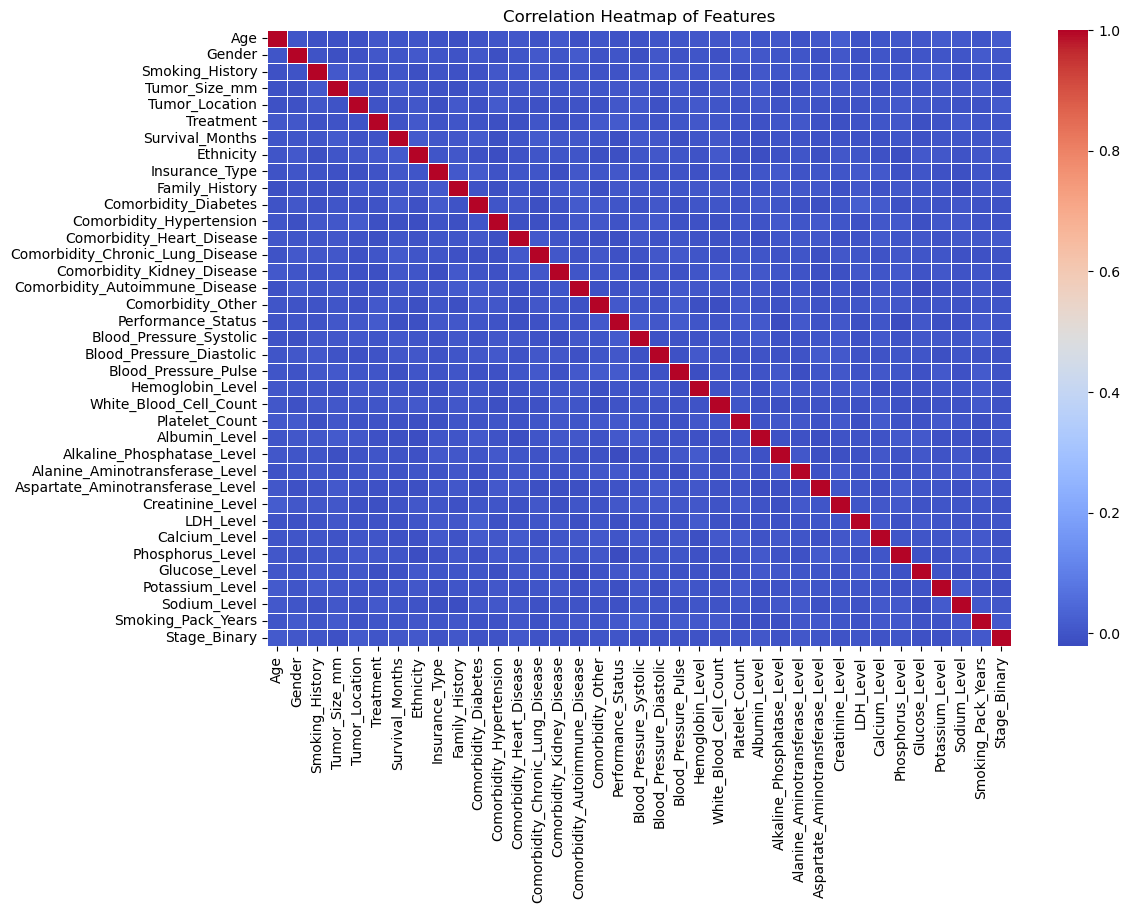

In [11]:
def plot_correlation_heatmap(df):
    """
    Plots a correlation heatmap for numerical variables.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
    """
    plt.figure(figsize=(12,8))
    sns.heatmap(df.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
    plt.title("Correlation Heatmap of Features")
    plt.show()

# Apply function
plot_correlation_heatmap(lung_cancer_data)
